In [ ]:
#default_exp data.block

In [ ]:
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.data.external import *
from local.notebook.showdoc import show_doc

In [ ]:
#hide
torch.cuda.set_device(int(os.environ.get('DEFAULT_GPU') or 0))

# Data block

> High level API to quickly get your data in a `DataBunch`

## General API

In [ ]:
#export
@docs
class DataBlock():
    "Generic container to quickly build `DataSource` and `DataBunch`"
    default_dl_tfms = Cuda
    def __init__(self, types=None, get_items=None, splitter=None, labeller=None):
        if types is not None:     self.types = types
        if get_items is not None: self.get_items = get_items 
        if splitter is not None:  self.splitter = splitter
        if labeller is not None:  self.labeller = labeller
            
    def get_items(self, source): pass
    def splitter(self, items): pass
    def labeller(self, item): pass
    
    def datasource(self, source, tfms=None, tuple_tfms=None):
        items = self.get_items(source)
        splits = self.splitter(items)
        if tfms is None: tfms = [L() for t in self.types]
        tfms = L(getattr(t, 'default_tfms', L()) + L(tfm) for (t,tfm) in zip(self.types, tfms))
        tfms = [tfms[0]] + [self.labeller + tfm for tfm in tfms[1:]]
        tfms = L(L(t() if isinstance(t, type) else t for t in tfm) for tfm in tfms)
        tuple_tfms = sum([getattr(t, 'default_tuple_tfms', L()) for t in self.types], L()) + L(tuple_tfms)
        tuple_tfms = L(t() if isinstance(t, type) else t for t in tuple_tfms)
        return DataSource(items, tfms=tfms, tuple_tfms=tuple_tfms, filts=splits)
    
    def databunch(self, source, tfms=None, tuple_tfms=None, dl_tfms=None, bs=16, **kwargs):
        dsrc = self.datasource(source, tfms=tfms, tuple_tfms=tuple_tfms)
        dl_tfms = sum([getattr(t, 'default_dl_tfms', L()) for t in self+L(self.types)], L()) + L(dl_tfms)
        dl_tfms = L(t() if isinstance(t, type) else t for t in dl_tfms)
        return dsrc.databunch(tfms=tfms, bs=bs, **kwargs)
    
    _docs = dict(get_items="Pass at init or implement how to get your raw items from a `source`",
                 splitter="Pass at init or implement how to split your `items`",
                 labeller="Pass at init or implement how to label a raw `item`",
                 datasource="Create a `Datasource` from `source` with `tfms` and `tuple_tfms`",
                 databunch="Create a `DataBunch` from `source` with `tfms`")

### Building a `DataBlock`

To build a `DataBlock` you need to give the lbirary four things: the types of your input/labels then three function.

In [ ]:
show_doc(DataBlock.get_items)

<h4 id="<code>DataBlock.get_items</code>" class="doc_header"><code>DataBlock.get_items</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/09_data_block.ipynb#General-API" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.get_items</code>(**`source`**)

Pass at init or implement how to get your raw items from a `source`

In [ ]:
show_doc(DataBlock.splitter)

<h4 id="<code>DataBlock.splitter</code>" class="doc_header"><code>DataBlock.splitter</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/09_data_block.ipynb#General-API" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.splitter</code>(**`items`**)

Pass at init or implement how to split your `items`

In [ ]:
show_doc(DataBlock.labeller)

<h4 id="<code>DataBlock.labeller</code>" class="doc_header"><code>DataBlock.labeller</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/09_data_block.ipynb#General-API" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.labeller</code>(**`item`**)

Pass at init or implement how to label a raw `item`

### Using a `DataBlock`

Once those informations are all provided, you automatically get a `DataSource` or a `DataBunch`:

In [ ]:
show_doc(DataBlock.datasource)

<h4 id="<code>DataBlock.datasource</code>" class="doc_header"><code>DataBlock.datasource</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/09_data_block.ipynb#General-API" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.datasource</code>(**`source`**, **`tfms`**=*`None`*, **`tuple_tfms`**=*`None`*)

Create a `Datasource` from `source` with `tfms` and `tuple_tfms`

In [ ]:
show_doc(DataBlock.databunch)

<h4 id="<code>DataBlock.databunch</code>" class="doc_header"><code>DataBlock.databunch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/09_data_block.ipynb#General-API" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.databunch</code>(**`source`**, **`tfms`**=*`None`*, **`tuple_tfms`**=*`None`*, **`dl_tfms`**=*`None`*, **`bs`**=*`16`*, **\*\*`kwargs`**)

Create a [`DataBunch`](/data.core.html#DataBunch) from `source` with `tfms`

## Examples

### Classification

In [ ]:
from local.vision.core import *
from local.vision.augment import *

In [ ]:
PILImage.default_tfms = Imagify
Category.default_tfms = Categorize
PILImage.default_tuple_tfms = [ImageConverter, ImageToByteTensor]

In [ ]:
class MNIST(DataBlock):
    types = (PILImage, Category)
    def get_items(self, source): return get_image_files(Path(source))
    def splitter(self, items): return GrandparentSplitter()(items)
    
    @staticmethod
    def labeller(item): return parent_label(item)

In [ ]:
mnist = MNIST().datasource(untar_data(URLs.MNIST_TINY))

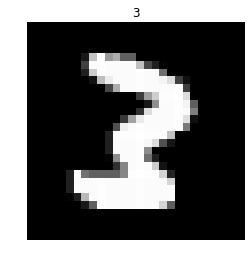

In [ ]:
mnist.train.show_at(0)

In [ ]:
mnist = DataBlock(types=(PILImage, Category), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  labeller=parent_label)

In [ ]:
dbunch = mnist.databunch(untar_data(URLs.MNIST_TINY))

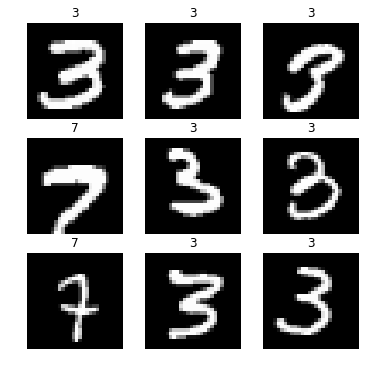

In [ ]:
_,axs = plt.subplots(3,3,figsize=(6,6))
dbunch.show_batch(ctxs = axs.flatten())

In [ ]:
pets = DataBlock(types=(PILImage, Category), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 labeller=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

In [ ]:
dbunch = pets.databunch(untar_data(URLs.PETS)/"images", tuple_tfms=Resize(128),
                        dl_tfms=aug_transforms())

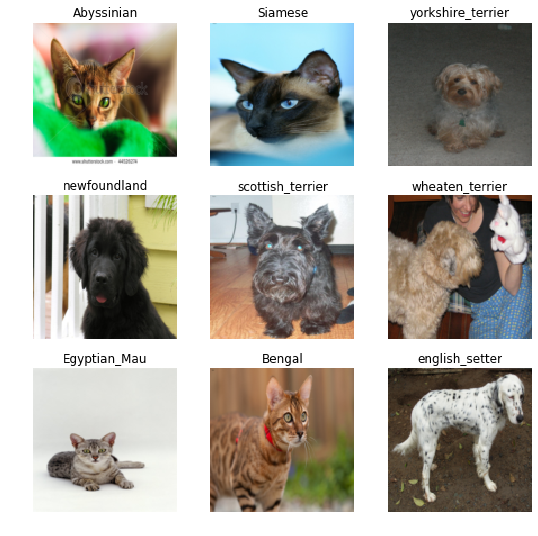

In [ ]:
_,axs = plt.subplots(3,3,figsize=(9,9))
dbunch.show_batch(ctxs = axs.flatten())

### Multi-label classification

### Segmentation

In [ ]:
Mask.default_tfms = Maskify

In [ ]:
camvid = DataBlock(types=(PILImage, Mask),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   labeller=lambda o: untar_data(URLs.CAMVID_TINY)/'labels'/f'{o.stem}_P{o.suffix}')

In [ ]:
dbunch = camvid.databunch(untar_data(URLs.CAMVID_TINY)/"images", dl_tfms=aug_transforms())

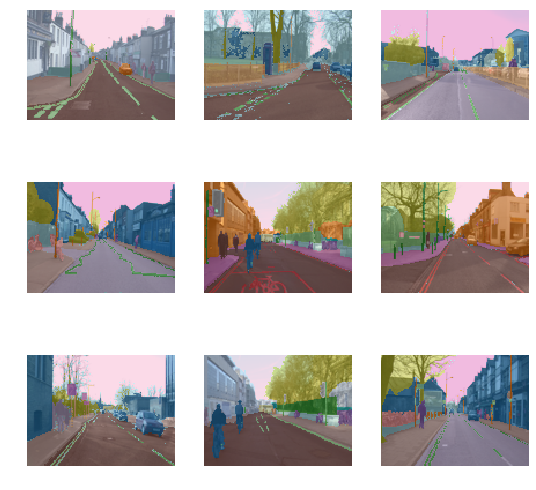

In [ ]:
_,axs = plt.subplots(3,3,figsize=(9,9))
dbunch.show_batch(ctxs = axs.flatten())

### Points

In [ ]:
TensorPoint.default_tfms = Pointify
TensorPoint.default_tuple_tfms = PointScaler

In [ ]:
biwi_source = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = pickle.load(open(biwi_source/'centers.pkl', 'rb'))

biwi = DataBlock(types=(PILImage, TensorPoint),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 labeller=lambda o:fn2ctr[o.name].flip(0))

In [ ]:
dbunch = biwi.databunch(biwi_source, dl_tfms=aug_transforms())

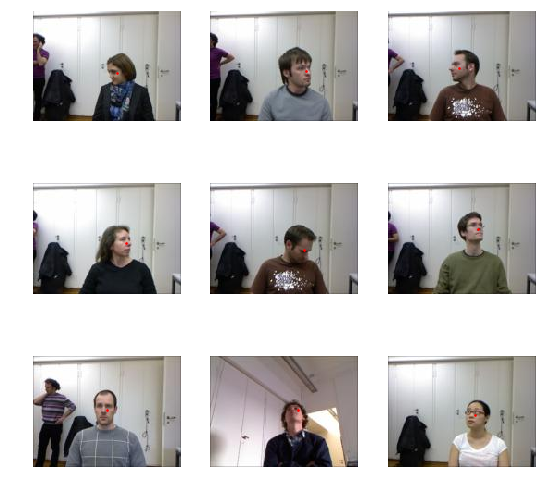

In [ ]:
_,axs = plt.subplots(3,3,figsize=(9,9))
dbunch.show_batch(ctxs = axs.flatten())

### Bounding boxes

In [ ]:
TensorBBox.default_tfms = [BBoxify, BBoxCategorize]
TensorBBox.default_tuple_tfms = BBoxScaler

In [ ]:
def bb_pad_collate(samples, pad_idx=0):
    "Function that collect `samples` of labelled bboxes and adds padding with `pad_idx`."
    if isinstance(samples[0][1], int): return data_collate(samples)
    max_len = max([len(s[1][1]) for s in samples])
    bboxes = torch.zeros(len(samples), max_len, 4)
    labels = torch.zeros(len(samples), max_len).long() + pad_idx
    imgs = []
    for i,s in enumerate(samples):
        imgs.append(s[0][None])
        bbs, lbls = s[1]
        if not (bbs.nelement() == 0):
            bboxes[i,-len(lbls):] = bbs
            labels[i,-len(lbls):] = tensor(lbls)
    return torch.cat(imgs,0), (bboxes,labels)

In [ ]:
coco_source = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco_source/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

coco = DataBlock(types=(PILImage, TensorBBox),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 labeller=lambda o: img2bbox[o.name])

In [ ]:
dbunch = coco.databunch(coco_source, tuple_tfms=Resize(128), dl_tfms=aug_transforms(), 
                        collate_fn=bb_pad_collate)

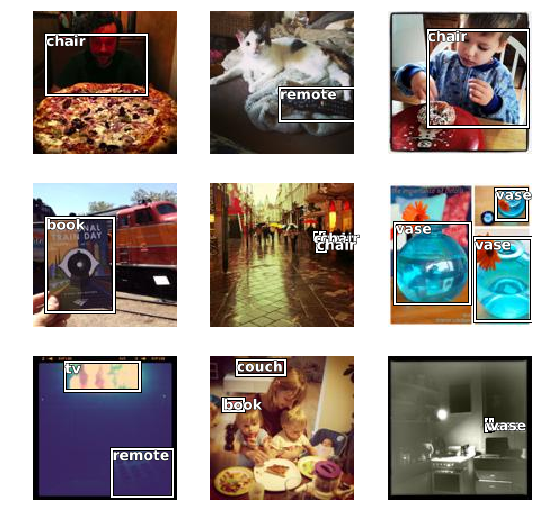

In [ ]:
_,axs = plt.subplots(3,3,figsize=(9,9))
dbunch.show_batch(ctxs = axs.flatten())